In [1]:
# Requirements

# numpy
# scikit-learn

# !pip install numpy scikit-learn


In [13]:
import os
import math
import json
import numpy as np
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

RNG = np.random.default_rng(42)

# utilities

In [4]:
def softmax(z):
    z = z - np.max(z, axis=1, keepdims=True)
    e = np.exp(z)
    return e / np.sum(e, axis=1, keepdims=True)

def one_hot(y, C):
    m = np.zeros((y.shape[0], C), dtype=float)
    m[np.arange(y.shape[0]), y] = 1.0
    return m

def mask_and_unmask(arr, seed=1234, scale=1e-3):
    # Simulate additive masking using a shared RNG seed
    rng = np.random.default_rng(seed)
    noise = rng.normal(0.0, scale, size=arr.shape)
    masked = arr + noise
    # On the "server" we can regenerate and subtract since seed is shared.
    return masked, noise

def approx_size_bytes(arrays):
    # Rough on-wire size (float64 assumed unless cast); we cast to float32 to be conservative
    total = 0
    for a in arrays:
        if a is None:
            continue
        total += a.astype(np.float32).nbytes
    return total

# Building a 2-view dataset

In [5]:
data = load_wine()
X, y = data.data.astype(np.float32), data.target.astype(int)
C = len(np.unique(y))
n, d = X.shape   # 178 x 13

In [6]:
# Split features to client A (first 6) and B (remaining 7)
idxA = np.arange(0, 6)
idxB = np.arange(6, d)

XA_full = X[:, idxA]
XB_full = X[:, idxB]


In [7]:
# Train/test split (test is fully overlapping for eval)
X_train_A, X_test_A, X_train_B, X_test_B, y_train, y_test = train_test_split(
    XA_full, XB_full, y, test_size=0.3, stratify=y, random_state=0
)

n_train = X_train_A.shape[0]

# Choose overlapping indices (e.g., 35% of train); rest become unaligned split across clients
for overlap_ratio in [0.1, 0.3, 0.5, 0.7]:
    n_overlap = int(round(overlap_ratio * n_train))


    perm = RNG.permutation(n_train)
    ov_idx = perm[:n_overlap]
    rest_idx = perm[n_overlap:]

    # Split the remaining (non-overlap) rows equally as unaligned A or unaligned B
    split_point = len(rest_idx) // 2
    ua_idx = rest_idx[:split_point]  # only at A
    ub_idx = rest_idx[split_point:]  # only at B
    # Overlapping sets (both clients have these feature rows; labels live ONLY on server)
    XA_o = X_train_A[ov_idx]
    XB_o = X_train_B[ov_idx]
    y_o  = y_train[ov_idx]  # lives on "server" only

    # Unaligned sets
    XA_u = X_train_A[ua_idx]  # only A has these
    XB_u = X_train_B[ub_idx]  # only B has these

# Client‑side unsupervised encoders (StandardScaler + PCA)

In [8]:
def fit_encoder(X_local, n_components):
    scaler = StandardScaler().fit(X_local)
    Xs = scaler.transform(X_local)
    pca = PCA(n_components=n_components, random_state=0).fit(Xs)
    return scaler, pca

def transform_encoder(scaler, pca, X):
    return pca.transform(scaler.transform(X))

In [9]:
dimA, dimB = 5, 5

# Fit on each client's OWN local data (overlap + its unaligned portion)
XA_local_all = np.vstack([XA_o, XA_u]) if XA_u.size else XA_o
XB_local_all = np.vstack([XB_o, XB_u]) if XB_u.size else XB_o

scA, pcaA = fit_encoder(XA_local_all, dimA)
scB, pcaB = fit_encoder(XB_local_all, dimB)

In [10]:
EA_o = transform_encoder(scA, pcaA, XA_o)
EB_o = transform_encoder(scB, pcaB, XB_o)

In [11]:
EA_u = transform_encoder(scA, pcaA, XA_u) if XA_u.size else np.zeros((0, dimA), dtype=np.float32)
EB_u = transform_encoder(scB, pcaB, XB_u) if XB_u.size else np.zeros((0, dimB), dtype=np.float32)


# Server trains linear softmax on overlap embeddings

In [14]:
H_o = np.concatenate([EA_o, EB_o], axis=1)
clf_server = LogisticRegression(
    multi_class="multinomial", solver="lbfgs", max_iter=200, random_state=0
).fit(H_o, y_o)

In [15]:
W = clf_server.coef_.astype(np.float32)      # shape [C, D]
b = clf_server.intercept_.astype(np.float32) # shape [C]

In [16]:
# Per‑sample gradient wrt input embeddings: grad_h = (softmax(z) - one_hot(y)) @ W
Z = H_o @ W.T + b
P = softmax(Z)
Y_onehot = one_hot(y_o, C).astype(np.float32)
Delta = (P - Y_onehot)  # [n_overlap, C]
grad_H = Delta @ W      # [n_overlap, D]

In [17]:
grad_A, grad_B = grad_H[:, :dimA], grad_H[:, dimA:]

# Mask (dummy encryption) on wire
grad_A_masked, noiseA = mask_and_unmask(grad_A, seed=111, scale=1e-3)
grad_B_masked, noiseB = mask_and_unmask(grad_B, seed=222, scale=1e-3)

In [18]:
payload_up_1 = approx_size_bytes([EA_o.astype(np.float32), EB_o.astype(np.float32)])
payload_down = approx_size_bytes([grad_A_masked.astype(np.float32), grad_B_masked.astype(np.float32)])

# "Clients" unmask upon receipt
grad_A_received = grad_A_masked - noiseA
grad_B_received = grad_B_masked - noiseB

# Clients: k‑means on gradients → temporary labels on overlap + local self‑training on unaligned

In [19]:
def local_phase(E_o, E_u, grad_o, C, selftrain_thr=0.85, random_state=0):
    # KMeans on gradients to get temp labels
    km = KMeans(n_clusters=C, n_init=10, random_state=random_state)
    y_temp = km.fit_predict(grad_o)

    # Supervised training on overlap embeddings → temp labels
    local_clf = LogisticRegression(
        multi_class="multinomial", solver="lbfgs", max_iter=200, random_state=random_state
    ).fit(E_o, y_temp)

    # Self‑training on unaligned (add confident predictions as extra labels)
    if E_u.shape[0] > 0:
        prob_u = local_clf.predict_proba(E_u)
        y_u = np.argmax(prob_u, axis=1)
        conf = prob_u.max(axis=1)
        keep = conf >= selftrain_thr
        if np.any(keep):
            E_sup = np.vstack([E_o, E_u[keep]])
            y_sup = np.concatenate([y_temp, y_u[keep]])
            local_clf = LogisticRegression(
                multi_class="multinomial", solver="lbfgs", max_iter=200, random_state=random_state
            ).fit(E_sup, y_sup)

    # Updated "embeddings" = pre‑softmax logits of local classifier
    #   z = E @ W_loc^T + b_loc
    W_loc = local_clf.coef_.astype(np.float32)      # [C, dim]
    b_loc = local_clf.intercept_.astype(np.float32) # [C]
    Z_o = E_o @ W_loc.T + b_loc  # [n_overlap, C]

    return Z_o, dict(local_clf=local_clf, W=W_loc, b=b_loc)


In [20]:
ZA_o, debugA = local_phase(EA_o, EA_u, grad_A_received, C, selftrain_thr=0.85, random_state=0)
ZB_o, debugB = local_phase(EB_o, EB_u, grad_B_received, C, selftrain_thr=0.85, random_state=1)


# Clients upload updated overlap representations (masked)

In [21]:
ZA_o_masked, noiseZA = mask_and_unmask(ZA_o, seed=333, scale=1e-3)
ZB_o_masked, noiseZB = mask_and_unmask(ZB_o, seed=444, scale=1e-3)

payload_up_2 = approx_size_bytes([ZA_o_masked.astype(np.float32), ZB_o_masked.astype(np.float32)])


In [22]:
# Server unmasks
ZA_o_recv = ZA_o_masked - noiseZA
ZB_o_recv = ZB_o_masked - noiseZB

H_o_updated = np.concatenate([ZA_o_recv, ZB_o_recv], axis=1)

In [23]:
# Retrain server classifier on updated embeddings
clf_server_2 = LogisticRegression(
    multi_class="multinomial", solver="lbfgs", max_iter=500, random_state=0
).fit(H_o_updated, y_o)

# Evaluate on test set (fully overlapping)

In [24]:
EA_test = transform_encoder(scA, pcaA, X_test_A)
EB_test = transform_encoder(scB, pcaB, X_test_B)

In [25]:
# Clients apply their learned local transformations to produce updated test reps
def local_logits(E, W, b):
    return E @ W.T + b

ZA_test = local_logits(EA_test, debugA["W"], debugA["b"])
ZB_test = local_logits(EB_test, debugB["W"], debugB["b"])
H_test = np.concatenate([ZA_test, ZB_test], axis=1)

y_pred = clf_server_2.predict(H_test)
acc = accuracy_score(y_test, y_pred)

# summary

In [26]:
comm_rounds = 3  # upload initial reps, download gradients, upload updated reps
payload_mb = (payload_up_1 + payload_down + payload_up_2) / (1024**2)

summary = {
    "n_train": int(n_train),
    "n_overlap": int(n_overlap),
    "n_unaligned_A": int(XA_u.shape[0]),
    "n_unaligned_B": int(XB_u.shape[0]),
    "clientA_embed_dim": int(dimA),
    "clientB_embed_dim": int(dimB),
    "classes": int(C),
    "comm_rounds": comm_rounds,
    "approx_payload_MB": round(float(payload_mb), 4),
    "test_accuracy": round(float(acc), 4)
}

print("=== One‑Shot VFL (simplified) — Results ===")
print(json.dumps(summary, indent=2))
print("\nClassification report (server on updated embeddings):")
print(classification_report(y_test, y_pred, digits=4))

=== One‑Shot VFL (simplified) — Results ===
{
  "n_train": 124,
  "n_overlap": 87,
  "n_unaligned_A": 18,
  "n_unaligned_B": 19,
  "clientA_embed_dim": 5,
  "clientB_embed_dim": 5,
  "classes": 3,
  "comm_rounds": 3,
  "approx_payload_MB": 0.0086,
  "test_accuracy": 0.7593
}

Classification report (server on updated embeddings):
              precision    recall  f1-score   support

           0     0.6667    0.8889    0.7619        18
           1     0.8000    0.9524    0.8696        21
           2     1.0000    0.3333    0.5000        15

    accuracy                         0.7593        54
   macro avg     0.8222    0.7249    0.7105        54
weighted avg     0.8111    0.7593    0.7310        54



# Experiment with 0.1, 0.3, 0.5, 0.7 overlap ratios.

In [30]:
results = []

for overlap_ratio in [0.1, 0.3, 0.5, 0.7]:
    print("\n==============================")
    print(f" Running with overlap_ratio = {overlap_ratio}")
    print("==============================")
    RNG = np.random.default_rng(42)

    # --- Partition overlap vs unaligned ---
    n_overlap = int(round(overlap_ratio * n_train))
    perm = RNG.permutation(n_train)
    ov_idx = perm[:n_overlap]
    rest_idx = perm[n_overlap:]
    split_point = len(rest_idx) // 2
    ua_idx, ub_idx = rest_idx[:split_point], rest_idx[split_point:]

    XA_o, XB_o, y_o = X_train_A[ov_idx], X_train_B[ov_idx], y_train[ov_idx]
    XA_u, XB_u = X_train_A[ua_idx], X_train_B[ub_idx]

    # --- Client-side encoders ---
    dimA, dimB = 5, 5
    XA_local_all = np.vstack([XA_o, XA_u]) if XA_u.size else XA_o
    XB_local_all = np.vstack([XB_o, XB_u]) if XB_u.size else XB_o

    scA, pcaA = fit_encoder(XA_local_all, dimA)
    scB, pcaB = fit_encoder(XB_local_all, dimB)

    EA_o = transform_encoder(scA, pcaA, XA_o)
    EB_o = transform_encoder(scB, pcaB, XB_o)
    EA_u = transform_encoder(scA, pcaA, XA_u) if XA_u.size else np.zeros((0, dimA))
    EB_u = transform_encoder(scB, pcaB, XB_u) if XB_u.size else np.zeros((0, dimB))

    # --- Server initial training ---
    H_o = np.concatenate([EA_o, EB_o], axis=1)
    clf_server = LogisticRegression(
        multi_class="multinomial", solver="lbfgs", max_iter=200, random_state=0
    ).fit(H_o, y_o)

    W, b = clf_server.coef_.astype(np.float32), clf_server.intercept_.astype(np.float32)
    Z = H_o @ W.T + b
    P = softmax(Z)
    Delta = P - one_hot(y_o, C)
    grad_H = Delta @ W
    grad_A, grad_B = grad_H[:, :dimA], grad_H[:, dimA:]

    # --- Masking ---
    grad_A_masked, noiseA = mask_and_unmask(grad_A, seed=111)
    grad_B_masked, noiseB = mask_and_unmask(grad_B, seed=222)
    payload_up_1 = approx_size_bytes([EA_o, EB_o])
    payload_down = approx_size_bytes([grad_A_masked, grad_B_masked])

    grad_A_received, grad_B_received = grad_A_masked - noiseA, grad_B_masked - noiseB

    # --- Local phase ---
    ZA_o, debugA = local_phase(EA_o, EA_u, grad_A_received, C, random_state=0)
    ZB_o, debugB = local_phase(EB_o, EB_u, grad_B_received, C, random_state=1)

    # --- Upload updated reps ---
    ZA_o_masked, noiseZA = mask_and_unmask(ZA_o, seed=333)
    ZB_o_masked, noiseZB = mask_and_unmask(ZB_o, seed=444)
    payload_up_2 = approx_size_bytes([ZA_o_masked, ZB_o_masked])

    ZA_o_recv, ZB_o_recv = ZA_o_masked - noiseZA, ZB_o_masked - noiseZB
    H_o_updated = np.concatenate([ZA_o_recv, ZB_o_recv], axis=1)

    clf_server_2 = LogisticRegression(
        multi_class="multinomial", solver="lbfgs", max_iter=500, random_state=0
    ).fit(H_o_updated, y_o)

    # --- Test evaluation ---
    EA_test = transform_encoder(scA, pcaA, X_test_A)
    EB_test = transform_encoder(scB, pcaB, X_test_B)
    ZA_test = local_logits(EA_test, debugA["W"], debugA["b"])
    ZB_test = local_logits(EB_test, debugB["W"], debugB["b"])
    H_test = np.concatenate([ZA_test, ZB_test], axis=1)

    y_pred = clf_server_2.predict(H_test)
    acc = accuracy_score(y_test, y_pred)

    comm_rounds = 3
    payload_mb = (payload_up_1 + payload_down + payload_up_2) / (1024**2)

    summary = {
        "n_train": int(n_train),
        "n_overlap": int(n_overlap),
        "n_unaligned_A": int(XA_u.shape[0]),
        "n_unaligned_B": int(XB_u.shape[0]),
        "clientA_embed_dim": int(dimA),
        "clientB_embed_dim": int(dimB),
        "classes": int(C),
        "comm_rounds": comm_rounds,
        "approx_payload_MB": round(float(payload_mb), 4),
        "test_accuracy": round(float(acc), 4),
    }

    print("=== One-Shot VFL (simplified) — Results ===")
    print(json.dumps(summary, indent=2))
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, digits=4))

    results.append({
        "overlap_ratio": overlap_ratio,
        "n_overlap": n_overlap,
        "accuracy": round(float(acc), 4)
    })



 Running with overlap_ratio = 0.1
=== One-Shot VFL (simplified) — Results ===
{
  "n_train": 124,
  "n_overlap": 12,
  "n_unaligned_A": 56,
  "n_unaligned_B": 56,
  "clientA_embed_dim": 5,
  "clientB_embed_dim": 5,
  "classes": 3,
  "comm_rounds": 3,
  "approx_payload_MB": 0.0012,
  "test_accuracy": 0.8889
}

Classification report:
              precision    recall  f1-score   support

           0     0.9474    1.0000    0.9730        18
           1     1.0000    0.7143    0.8333        21
           2     0.7500    1.0000    0.8571        15

    accuracy                         0.8889        54
   macro avg     0.8991    0.9048    0.8878        54
weighted avg     0.9130    0.8889    0.8865        54


 Running with overlap_ratio = 0.3
=== One-Shot VFL (simplified) — Results ===
{
  "n_train": 124,
  "n_overlap": 37,
  "n_unaligned_A": 43,
  "n_unaligned_B": 44,
  "clientA_embed_dim": 5,
  "clientB_embed_dim": 5,
  "classes": 3,
  "comm_rounds": 3,
  "approx_payload_MB": 0.0037,
 

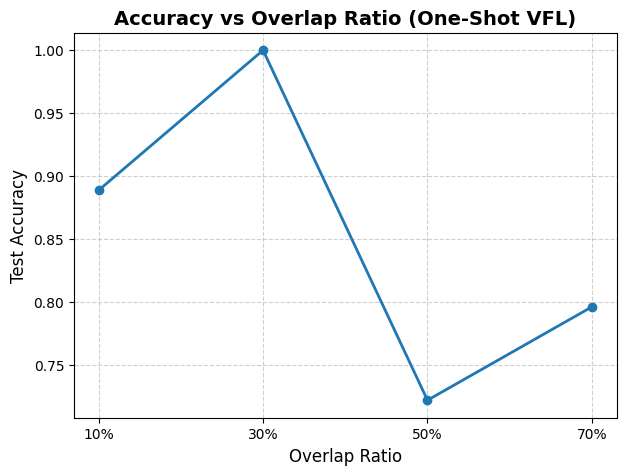

In [31]:
# --- Plotting ---
ratios = [r["overlap_ratio"] for r in results]
accs = [r["accuracy"] for r in results]

plt.figure(figsize=(7,5))
plt.plot(ratios, accs, marker="o", linewidth=2)
plt.title("Accuracy vs Overlap Ratio (One-Shot VFL)", fontsize=14, fontweight="bold")
plt.xlabel("Overlap Ratio", fontsize=12)
plt.ylabel("Test Accuracy", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(ratios, [f"{int(r*100)}%" for r in ratios])
plt.show()

In [32]:
import pandas as pd
df = pd.DataFrame(results)
print(df)

   overlap_ratio  n_overlap  accuracy
0            0.1         12    0.8889
1            0.3         37    1.0000
2            0.5         62    0.7222
3            0.7         87    0.7963
